<a href="https://colab.research.google.com/github/Kussil/CVX_Rice_project/blob/main/06_Query_Vector_DB/Query_Vector_Database.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install Dependenies
!pip install -q -U langchain transformers bitsandbytes accelerate
!pip install -q sentence-transformers
!pip install -q pinecone
!pip install -q langchain_community

In [2]:
# imports
import torch

In [3]:
# Import github token with google secrets thingy and clone git repository
import os
from google.colab import userdata
GITHUB_TOKEN = userdata.get('github')
os.environ['GITHUB_TOKEN'] = GITHUB_TOKEN
!git clone https://{GITHUB_TOKEN}@github.com/Kussil/CVX_Rice_project.git

fatal: destination path 'CVX_Rice_project' already exists and is not an empty directory.


In [4]:
import pandas as pd
df_chunk = pd.read_csv('/content/CVX_Rice_project/03_Sentiment_Analysis/sentiment_chunkdata.csv')
df = pd.read_csv('/content/CVX_Rice_project/03_Sentiment_Analysis/sentiment_data.csv')

#def convert_string(string):
#  return string[2:-2].split("', ")

#df['Text Chunks']=df['Text Chunks'].apply(convert_string)
#df['Date'] = pd.to_datetime(df['Date'], format='mixed')
#df

### Pull Models

In [5]:
from pinecone import Pinecone, ServerlessSpec

pc = Pinecone(api_key="bc4ea65c-d63e-48e4-9b65-53d6272d927d")

from sentence_transformers import SentenceTransformer

embedding_model = SentenceTransformer("all-mpnet-base-v2")

# Import Libraries
import torch
from transformers import BitsAndBytesConfig
from langchain import HuggingFacePipeline
from langchain import PromptTemplate, LLMChain
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

# Define Quantization
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True)

# Load Model and Tokenizer
from google.colab import userdata
HF_TOKEN = userdata.get('hf')
os.environ['HF_TOKEN'] = HF_TOKEN
model_4bit = AutoModelForCausalLM.from_pretrained( "meta-llama/Meta-Llama-3-8B-Instruct",
                                                  device_map="auto",
                                                   quantization_config=quantization_config,
                                                   token={HF_TOKEN})
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Meta-Llama-3-8B-Instruct", token={HF_TOKEN})

# Create Hugging Face Pipeline
pipeline_inst = pipeline(
        "text-generation",
        model=model_4bit,
        tokenizer=tokenizer,
        use_cache=True,
        device_map="auto",
        max_length=6000,
        do_sample=True,
        top_k=1,
        num_return_sequences=1,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id)

llm = HuggingFacePipeline(pipeline=pipeline_inst)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The class `HuggingFacePipeline` was deprecated in LangChain 0.0.37 and will be removed in 0.3. An updated version of the class exists in the from rom langchain-huggingface package and should be used instead. To use it run `pip install -U from rom langchain-huggingface` and import as `from from rom langchain_huggingface import llms import HuggingFacePipeline`.
  warn_deprecated(


In [13]:
#run similarity search


def ask_vector_query(query, top_results, date=None, pinecone_index="newsembedding3"):

  query_embeddings = embedding_model.encode(query)

  # date filter for vector database
  if date==None:
    filter = {}
  else:
    filter={
        "date": {"$eq": date}
      }

  index = pc.Index(pinecone_index)

  output = index.query(
      namespace="ns1",
      vector=[float(i) for i in list(query_embeddings)],
      filter=filter,
      top_k=top_results,
      include_values=False,
      include_metadata=True
  )
  print(output['matches'])

  retrieved_text = ' '
  for i in range(len(output['matches'])):
    chunk_idx = output['matches'][i]['id']
    chunk_text = df_chunk['Text Chunks'].iloc[int(chunk_idx)]
    print(chunk_text)
    retrieved_text += ' ' + chunk_text

  #print(retrieved_text)

  # Prompt and response function
  template = """<s>Given the text from a financial news article, analyze the content and produce an answer to the provided query:

          **Constraints:** ONLY RESPOND USING THE PROVIDED Context/n/n

          The context from the financial news article excerpts below:
          {article}

          Query:
          {query}
          Respond in less than 100 words
          </s>
          """

  with torch.no_grad():
    prompt = PromptTemplate(template=template, input_variables=["article","query"])
    llm_chain = LLMChain(prompt=prompt, llm=llm)
    #print('start llm')
    full_response = llm_chain.run({"article":retrieved_text, "query":query})
    #print('end llm')
  split_response = full_response.split("</s>", 1)
  final_response = split_response[1]
  return final_response

In [15]:
# Test Function
import textwrap
with torch.no_grad():
  query = "What company is chevron trying to acquire?"
  top_results = 3
  pinecone_index = "newsembedding3"
  print(textwrap.fill(ask_vector_query(query, top_results, date=None, pinecone_index = "newsembedding3"), width=80))

[{'id': '852',
 'metadata': {'date': '2021-01-02',
              'neg': 0.9277880787849426,
              'neu': 0.0520099587738513,
              'pos': 0.0202019698917865,
              'ticker': 'CVX'},
 'score': 0.721340835,
 'values': []}, {'id': '240',
 'metadata': {'date': '2023-06-24',
              'neg': 0.9277880787849426,
              'neu': 0.0520099587738513,
              'pos': 0.0202019698917865,
              'ticker': 'CVX'},
 'score': 0.721340835,
 'values': []}, {'id': '529',
 'metadata': {'date': '2022-04-16',
              'neg': 0.8846030831336975,
              'neu': 0.1034844815731048,
              'pos': 0.0119124138727784,
              'ticker': 'CVX'},
 'score': 0.705595195,
 'values': []}]
[CLS] research note april 29, 2019 chevron corporation symbol : cvx cfra keeps buy opinion on shares of chevron corporation recent price : $ 117. 90 recommendation : the associated press is reporting that buyout target anadarko petroleum ( apc 73 * * * ) has re - ope

# Query from Interactive Plot

In [ ]:
!pip install -q ipympl

In [ ]:
from google.colab import output
import textwrap
output.enable_custom_widget_manager()

In [ ]:
import yfinance as yf
ticker = 'CVX'
price = yf.download(ticker, start="2024-04-01")["Adj Close"]
ret = price.pct_change().dropna()
ret.name = "ret"
ret.describe()

[*********************100%%**********************]  1 of 1 completed


count    36.000000
mean      0.000507
std       0.009456
min      -0.030421
25%      -0.004994
50%       0.002258
75%       0.005683
max       0.017903
Name: ret, dtype: float64

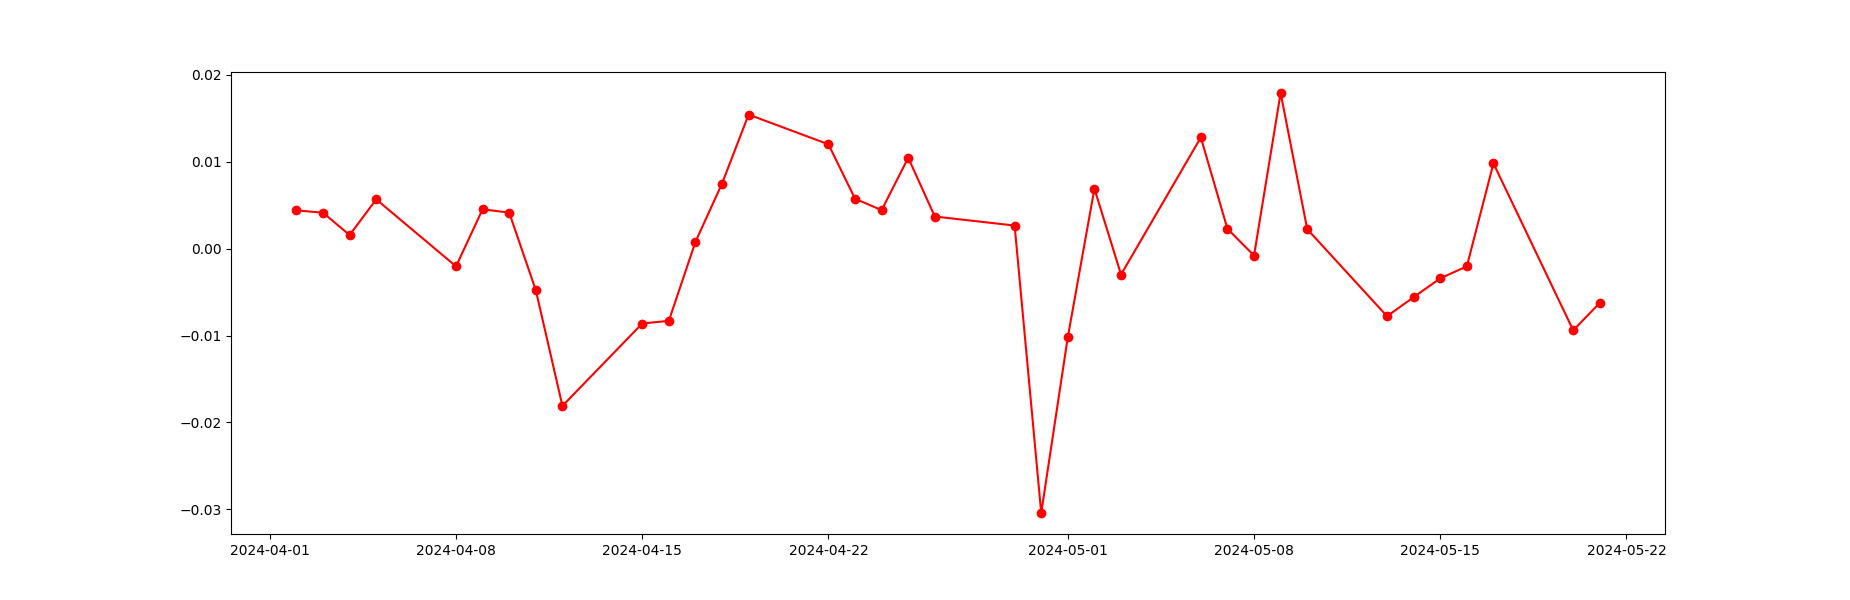

2024-05-03
[{'id': '1271',
 'metadata': {'date': '2024-05-03',
              'neg': 0.7261049598455429,
              'neu': 0.10787554644048214,
              'pos': 0.16601951303891838,
              'ticker': 'SHEL'},
 'score': 0.551066101,
 'values': []}, {'id': '11806',
 'metadata': {'date': '2024-05-03',
              'neg': 0.5206455886363983,
              'neu': 0.4159616231918335,
              'pos': 0.06339280772954226,
              'ticker': 'XOM'},
 'score': 0.548305,
 'values': []}, {'id': '11809',
 'metadata': {'date': '2024-05-03',
              'neg': 0.3738068987925847,
              'neu': 0.04012757415572802,
              'pos': 0.5860655307769775,
              'ticker': 'XOM'},
 'score': 0.545144379,
 'values': []}]
Unnamed: 0                                                       1271
Ticker                                                           SHEL
Date                                                       2024-05-03
Article Headline                       

In [ ]:
%matplotlib ipympl
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime

fig, ax = plt.subplots()
fig.set_size_inches(18.5, 6, forward=True)

tolerance = 2 # points
ax.plot(ret.index, ret, 'ro-', picker=tolerance)

def onclick(event):
    line = event.artist
    xdata, ydata = line.get_data()
    ind = event.ind
    datetime_obj  = xdata[ind][0].astype('datetime64[s]').astype(datetime)
    formatted_date = datetime_obj.strftime('%Y-%m-%d')
    print(formatted_date)
    query = 'summarize the top news articles for chevron?'
    top_results = 3
    print(textwrap.fill(ask_vector_query(query, top_results, date=str(formatted_date), pinecone_index = "newsembedding3"), width=80))

#cid = fig.canvas.mpl_connect('button_press_event', onclick)
cid = fig.canvas.mpl_connect('pick_event', onclick)